# Emulating some network conditions

---

- Website: https://discovery.gitlabpages.inria.fr/enoslib/index.html
- Instant chat: https://framateam.org/enoslib
- Source code: https://gitlab.inria.fr/discovery/enoslib

---

## Prerequisites

<div class="alert alert-block alert-warning">
    Make sure you've run the one time setup for your environment
</div>


## First example: a star topology

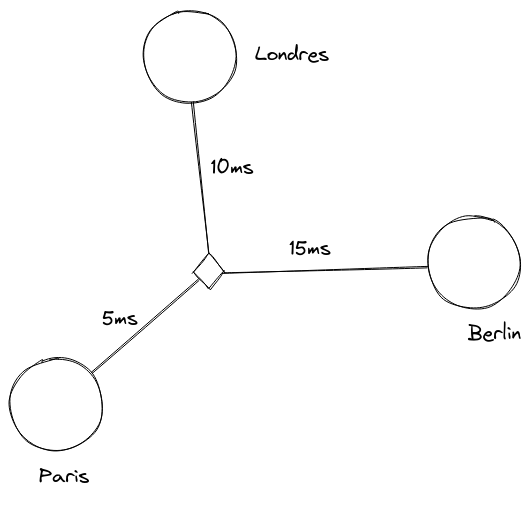

### Reservation

In [ ]:
import enoslib as en


_ = en.init_logging()


prod_network = en.G5kNetworkConf(type="prod", roles=["my_network"], site="rennes")
conf = (
    en.G5kConf.from_settings(job_type="allow_classic_ssh", walltime="01:00:00", job_name="labs_netem")
    .add_network_conf(prod_network)
    .add_machine(
        roles=["city", "paris"],
        cluster="paravance",
        nodes=1,
        primary_network=prod_network,
    )
    .add_machine(
        roles=["city", "berlin"],
        cluster="paravance",
        nodes=1,
        primary_network=prod_network,
    )
    .add_machine(
        roles=["city", "londres"],
        cluster="paravance",
        nodes=1,
        primary_network=prod_network,
    )
    .finalize()
)

provider = en.G5k(conf)
roles, networks = provider.init()

In [ ]:
roles

In [ ]:
networks

### Applying the network constraints

In [ ]:
roles = en.sync_info(roles, networks)
netem = en.Netem()

(
    netem
        .add_constraints("delay 5ms", roles["paris"], symetric=True)
        .add_constraints("delay 10ms", roles["londres"], symetric=True)
        .add_constraints("delay 15ms", roles["berlin"], symetric=True)
)

netem.deploy()



### Checking the network constraints

In [ ]:
netem.validate(output_dir="star_topology")

In [ ]:
import pandas as pd
stats = en.Netem.fping_stats("star_topology")
pd.DataFrame(stats, columns=["src", "dest", "ping values"])

In [ ]:
roles

In [ ]:
netem.destroy()

## Second example: a more flexible topology

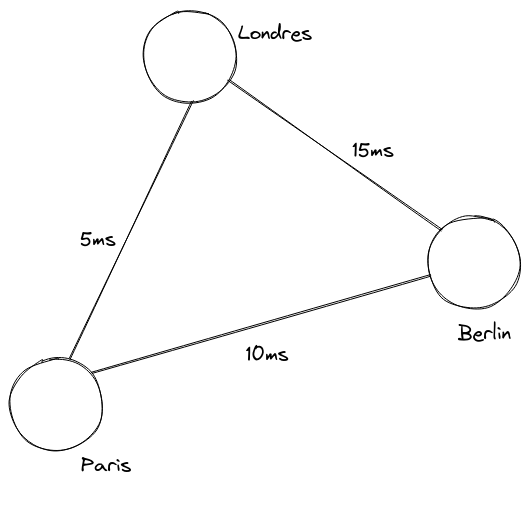

In [ ]:
roles = en.sync_info(roles, networks)

In [ ]:
netem = en.NetemHTB()

(
    netem.add_constraints(
        src=roles["paris"],
        dest=roles["londres"],
        delay="5ms",
        rate="1gbit",
        symetric=True,
    )
    .add_constraints(
        src=roles["paris"],
        dest=roles["berlin"],
        delay="10ms",
        rate="1gbit",
        symetric=True,
    )

    .add_constraints(
        src=roles["londres"],
        dest=roles["berlin"],
        delay="15ms",
        rate="1gbit",
        symetric=True,
    )
)

In [ ]:
_ = netem.deploy()

In [ ]:
netem.validate(output_dir="custom_topology")

In [ ]:
import enoslib as en
import pandas as pd
stats = en.Netem.fping_stats("custom_topology")
pd.DataFrame(stats, columns=["src", "dest", "ping values"])

In [ ]:
netem.destroy()

### Filter on specific network

In [ ]:
# enable ipv6
en.run_command("dhclient -6 br0", roles=roles)
# sync the info
roles = en.sync_info(roles, networks)

In [ ]:
networks

In [ ]:
ipv6_network = networks["my_network"][1]
ipv6_network

In [ ]:
netem = en.NetemHTB()

(
    netem.add_constraints(
        src=roles["paris"],
        dest=roles["londres"],
        delay="5ms",
        rate="1gbit",
        symetric=True,
        networks=[ipv6_network]
    )
    .add_constraints(
        src=roles["paris"],
        dest=roles["berlin"],
        delay="10ms",
        rate="1gbit",
        symetric=True,
        networks=[ipv6_network]
    )

    .add_constraints(
        src=roles["londres"],
        dest=roles["berlin"],
        delay="15ms",
        rate="1gbit",
        symetric=True,
        networks=[ipv6_network]
    )
)

In [ ]:
netem.deploy()

In [ ]:
netem.validate(output_dir="custom_topology_ipv6")

In [ ]:
import enoslib as en
import pandas as pd
stats = en.Netem.fping_stats("custom_topology_ipv6")
pd.DataFrame(stats, columns=["src", "dest", "ping values"])

In [ ]:
provider.destroy()

## Scaling

With this we can emulate a multiple Datacenter topology. Intra datacenter link are subject to LAN links while inter-datacenter topology are subject to WAN links.

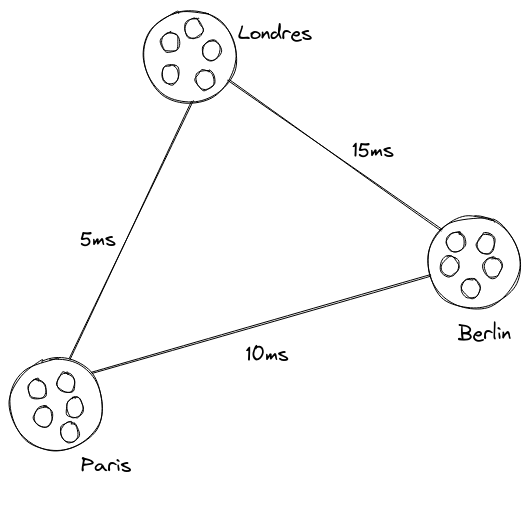

In [ ]:
conf = (
    en.VMonG5kConf
        .from_settings(job_name="labs_netem")
        .add_machine(
            roles=["city", "paris"],
            cluster="paravance",
            number=5,
            flavour="tiny"
        )
        .add_machine(
            roles=["city", "londres"],
            cluster="paravance",
            number=5,
            flavour="tiny"
        )
        .add_machine(
            roles=["city", "berlin"],
            cluster="paravance",
            number=5,
            flavour="tiny"
        )
        .finalize()
)
conf

In [ ]:
vmon5k = en.VMonG5k(conf)
vm_roles, vm_networks = vmon5k.init()

In [ ]:
vm_roles = en.sync_info(vm_roles, vm_networks)

In [ ]:
netem = en.NetemHTB()
(
    netem.add_constraints(
        src=vm_roles["paris"],
        dest=vm_roles["londres"],
        delay="5ms",
        rate="1gbit",
        symetric=True,
    )
    .add_constraints(
        src=vm_roles["paris"],
        dest=vm_roles["berlin"],
        delay="10ms",
        rate="1gbit",
        symetric=True,
    )

    .add_constraints(
        src=vm_roles["londres"],
        dest=vm_roles["berlin"],
        delay="15ms",
        rate="1gbit",
        symetric=True,
    )
)
netem

In [ ]:
_ = netem.deploy()

In [ ]:
netem.validate(output_dir="scaling_topology")

In [ ]:
import enoslib as en
import pandas as pd
stats = en.Netem.fping_stats("scaling_topology")
pd.DataFrame(stats, columns=["src", "dest", "ping values"])